<a href="https://colab.research.google.com/github/RafiKepecs/Bayesian-Machine-Learning/blob/main/Project%207%3A%20Change-point%20Detection/BayesML_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

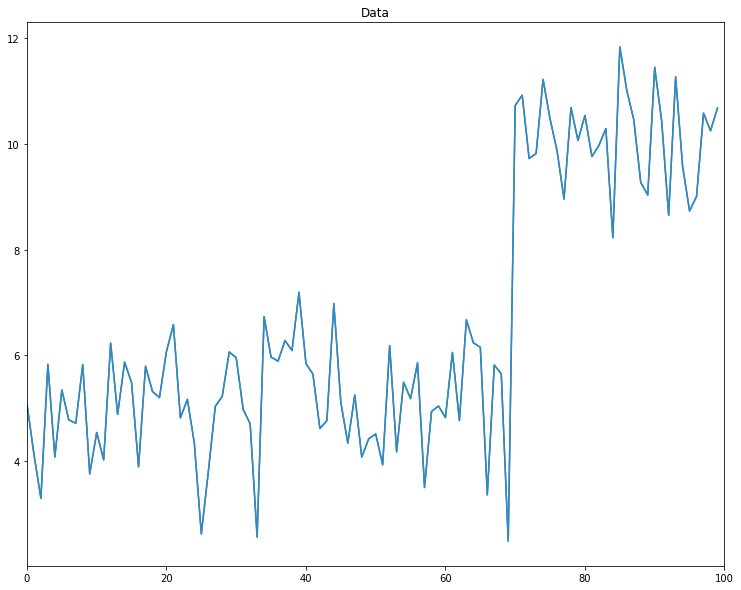

In [ ]:
#%% Changepoint Model Parameters

# Total number of samples
N = 100

# Changepoint
t = 70

# First distribution
mu1 = 5
sig1 = 1

# Second distribution
mu2 = 10
sig2 = 1


#%% Generate Changepoint Model Data

# Generate first-distribution data
x1 = np.random.normal(mu1, sig1, t)

# Generate second-distribution data
x2 = np.random.normal(mu2, sig2, N-t)

# Combine data to form changepoint signal
count_data = np.concatenate((x1, x2))

# Plot combined signal
plt.figure()
plt.plot(range(N), count_data)

n_count_data = len(count_data)
plt.plot(np.arange(n_count_data), count_data, color="#348ABD")
plt.title("Data")
plt.xlim(0, n_count_data);

In [ ]:
import pymc3 as pm
import theano.tensor as tt
#Resource: https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb

#%% Find Distribution Parameters

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    beta = 0.1
    lambda_1 = pm.Gamma("lambda_1", alpha, beta)
    lambda_2 = pm.Gamma("lambda_2", alpha, beta)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=500,step=step)

lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 2 chains for 500 tune and 10_000 draw iterations (1_000 + 20_000 draws total) took 9 seconds.
The number of effective samples is smaller than 10% for some parameters.


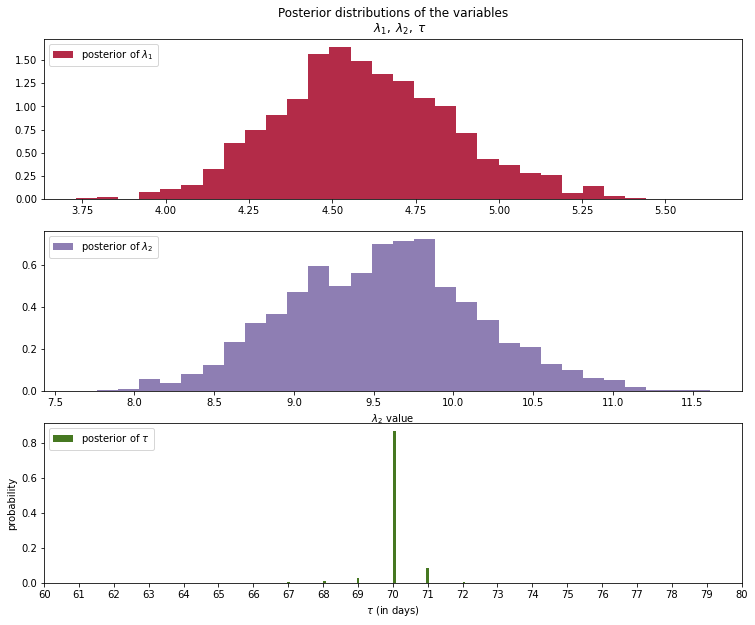

In [ ]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")

ax = plt.subplot(312)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
#plt.ylim([0, .5])
plt.xlim([60, 80])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

In [ ]:
!pip install ruptures

     |████████████████████████████████| 918 kB 4.7 MB/s 


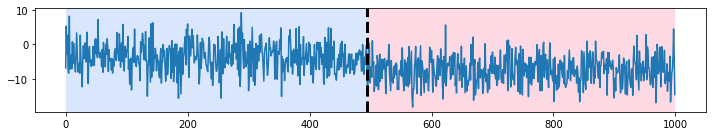

In [ ]:
# Sources: https://github.com/deepcharles/ruptures

import matplotlib.pyplot as plt
import ruptures as rpt

# generate signal
n_samples, dim, sigma = 1000, 1, 4
n_bkps = 1  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
result = algo.predict(pen=10)

# display
rpt.display(signal, bkps, result)
plt.show()